In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.optimize import curve_fit
from math import pi

In [ ]:
## Counting photons at each sDOM distance from POCAM2 to determine abs/att length
# Check events under peak, and events under entire curve
# number of events is proportional to intensity, which follows (1/r^2)*exp(-r/lambda)

# CORRECTIONS: noise/background, multi-photon events, dead time of the detector (characterized by faulty timestamps)

In [35]:
## read and clean data

path_meas = 'Data/POSEIDON1/Measured_arrival_times/'
sDOM_list = ['5', '1', '2', '3'] 
peak_photons = []
total_photons = []

for DOM_num in sDOM_list:

    # Get measurement data
    file = "['P2'],['SDOM%s'],up,violet,['20V'],['2500Hz'].csv"%DOM_num
    my_data = np.genfromtxt(path_meas+file, delimiter=',')
    times = my_data[0][:]
    counts = my_data[1][:]

    time_interval = (times[-1] - times[0])/len(times) # 1ns
    noise = np.mean(counts[0:85]) # time -100 to -15 ns

    counts_bkg_removed = np.array([max(0,hits-noise) for hits in counts])

    counts_peak = np.sum(counts_bkg_removed[(times>-10) & (times<10)])
    counts_total = np.sum(counts_bkg_removed)
    
    peak_photons = np.append(peak_photons,counts_peak)
    total_photons = np.append(total_photons,counts_total)

print('sDOM_list:     ', sDOM_list)
print('peak_photons:  ', peak_photons)
print('total_photons: ', total_photons)




sDOM_list:      ['5', '1', '2', '3']
peak_photons:   [83490.82352941 16020.64705882  9327.45431981  1915.85665641]
total_photons:  [86863.31764706 20368.41176471 14919.1968159   3811.54683744]


effective attenuation length:  36.55430518082025


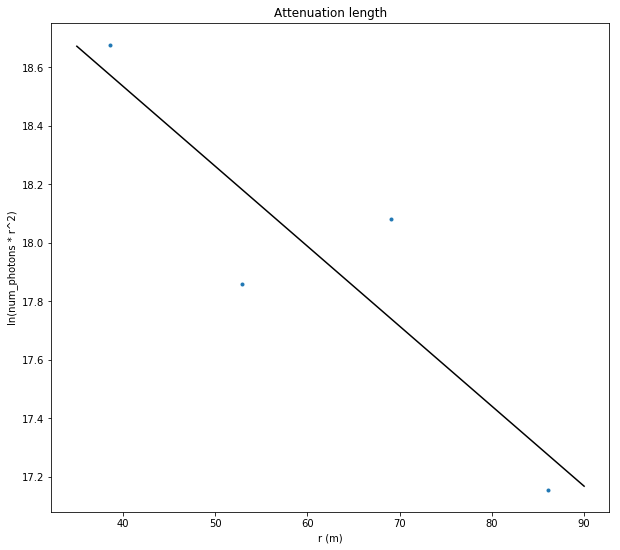

In [47]:
## Plot results and determine attenuation length

#path_meas = 'Data/POSEIDON1/Measured_arrival_times/'
sDOM_list = ['5', '1', '2', '3'] 
sDOM_dist_list = np.array([38.56, 52.94, 69.02, 86.04]) # m

y_direct_photons = np.log(peak_photons*np.power(sDOM_dist_list,2))
y_all_photons = np.log(total_photons*np.power(sDOM_dist_list,2))

x_fit = np.linspace(35,90)
p = np.polyfit(sDOM_dist_list,y_all_photons,1)
y_fit = np.polyval(p,x_fit)

# plot ln(num_photons*r^2) vs r
fig, ax = plt.subplots(figsize=(10,9))
ax.plot(sDOM_dist_list,y_all_photons,marker='.',linestyle='')
ax.plot(x_fit,y_fit,color='k')
ax.set_title('Attenuation length')
ax.set_ylabel('ln(num_photons * r^2)')
ax.set_xlabel('r (m)')
plt.savefig('Data/POSEIDON1/Optimization/attenuation_length.png',bbox_inches='tight')

eff_att_len = -1/p[0]
print('effective attenuation length: ', eff_att_len)


In [46]:
## Attenuation, scattering, and absorption

# example values for now
eta = .22
scatt_len = 17.25
abs_len = 60
avg_cos = (1-eta)*0.924 #average cosine of the scattering angle

eff_scatt = scatt_len/(1-avg_cos)
print('eff_scatt: ', eff_scatt)

eff_att_len_theoretical = 1 / (1/eff_scatt + 1/abs_len)
print('eff_att_len: ',eff_att_len_theoretical)



eff_scatt:  61.765969636207394
eff_att_len 30.4350894526977
